# FIT5202 Data processing for big data Assignment 1

##  Part B: Analysing CSV Data 
In this part, you will analyze crime data from South Australia. The dataset reflects                             reported incidents of crime (suburb-based crime statistics for crimes against the person                         and crimes against property.) that occurred in South Australia since 2010.     

Required Dataset (available in Moodle): 
- Crime_Statistics_SA_2010_present.csv  

##  Step 01: Import ​pyspark ​and initialize Spark
You will use ​SparkContext ​from ​pyspark​, which is the main entry point for Spark                             Core functionality. The ​SparkSession ​object provides methods used to create                     DataFrames ​from various input sources. A​DataFrame​is equivalent to a relational table in                             Spark SQL and can be created using various functions in ​SparkSession​. Once created, it                             can be manipulated using the various domain-specific-language (DSL) functions defined                     in ​DataFrame​, ​Column​.    

Write the code to create a ​ S p a r k C o n t e x t ​ object, which tells Spark how to access a                              cluster. ​ To create a SparkContext you first need to build a​SparkConf​object that contains                              information about your application. Give an appropriate name for your application and                         run Spark locally with as many working processors as logical cores on your machine.                             Write the code to create a​SparkSessionobject that can be used to create the data frame                                   from the input data source (CSV file). 


In [1]:
# import all the packages needed at begining
import os
from pyspark import SparkContext 
from pyspark.sql import SparkSession 
from datetime import datetime
from pyspark.sql.functions import udf, date_format
from pyspark.sql.types import DateType, StringType, BooleanType, IntegerType
import matplotlib.pyplot as mp
import matplotlib.dates as md

In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# Create or reuse the spark context.
sc = SparkContext.getOrCreate()
if (sc is None):
    sc = SparkContext(master="local[*]")
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("Assignment1 Part B")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/5202.ass1")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/5202.ass1")\
        .getOrCreate()

##  Step 02: Create Dataframe  
Write the code to create a data frame and provide the data source as the CSV file.  How many records are there in the data frame? 


In [3]:
# Read the csv to dataframe.
df = spark.read.csv('Crime_Statistics_SA_2010_present.csv', header = True, inferSchema = True)
df.count()

727408

### Answer:
There are 727408 records in the data frame including the header

##  Step 03: Write to Database  
We will use MongoDB as our data source. Therefore, as a data loading step, you                               are required to ​read the CSV file using spark session and insert all the records into                                 MongoDB. ​ Use the ​overwrite ​mode when you are inserting the data. 


In [4]:
# Write the dataframe to MongoDB.
df.write.format('com.mongodb.spark.sql.DefaultSource').mode('overwrite').save()

##  Step 04: Read from Database  
Create a Spark DataFrame to hold data from the MongoDB collection specified in                           the ​spark.mongodb.input.uri option which your SparkSession option is using. Display the                       schema of the data frame. ​You will use this new data frame to perform all the steps                                   mentioned below. 

In [5]:
# Read the saved data from MongoDB.
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



##  Step 05: Calculate the statistics of numeric and string columns  
Calculate the statistics of "Offence Count" and "Reported Date". ​Find the count,                         mean, standard deviation, minimum and maximum for these attributes ​ . Explain with                      reasoning whether the minimum and maximum reported date is correct. 

In [6]:
# Use describe() to calculate the statistics.
df.select('Offence Count','Reported Date').describe().show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev|0.5787050930378103|         null|
|    min|                 1|    1/01/2011|
|    max|                28|    9/12/2018|
+-------+------------------+-------------+



### Answer
The minimum and maximum reported date is incorrect. The type of date is str, so it rank firstly by day, instead of year. Also, because it is str, it can't correctly rank the number. For example, for number, 10 is greater than 9. However, for str type, 9 is greater than 10.

##  Step 06: Change the data type of a column  
The ​Date ​column is in string format. You need to change it to date format using the  user-defined functions (udf). 

In [7]:
# Create a udf to change the String type to Date type.
toDate = udf(lambda x : datetime.strptime(x, '%d/%m/%Y'), DateType())

# Create a udf to filter the null value in a column.
dropNone = udf(lambda x : not (x is None), BooleanType())

# Change the String date to Date type.
df_date = df.filter(dropNone('Reported Date')).withColumn('Reported Date',toDate('Reported Date'))
df_date.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



##  Step 07: Preliminary data analysis  
Write the code to answer the following analytical queries.  
- How many level 2 offences are there? Display the list of level 2 offences.  
- What is the number of offences against the person?  
- How many serious criminal tresspasses with more than 1 offence count?  
- What percentage of crimes are offences against the property? 


### Question 1
How many level 2 offences are there? Display the list of level 2 offences.

In [8]:
# Show the unique recording in this column.
df_lv2 = df_date.select('Offence Level 2 Description').distinct()
print(df_lv2.count())
df_lv2.show(truncate = False)

9
+------------------------------------+
|Offence Level 2 Description         |
+------------------------------------+
|ROBBERY AND RELATED OFFENCES        |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |
|SEXUAL ASSAULT AND RELATED OFFENCES |
|HOMICIDE AND RELATED OFFENCES       |
|ACTS INTENDED TO CAUSE INJURY       |
|SERIOUS CRIMINAL TRESPASS           |
|OTHER OFFENCES AGAINST THE PERSON   |
|FRAUD DECEPTION AND RELATED OFFENCES|
|THEFT AND RELATED OFFENCES          |
+------------------------------------+



### Answer 1
There are 9 kinds of level 2 offences in total. The list are shown above.

### Question 2
What is the number of offences against the person?

In [9]:
# Filter the offences and aggrate it to count the total number.
df_date.filter(df_date['Offence Level 1 Description'] == 'OFFENCES AGAINST THE PERSON')\
    .groupby('Offence Level 1 Description').sum('Offence Count').show(truncate = False)

+---------------------------+------------------+
|Offence Level 1 Description|sum(Offence Count)|
+---------------------------+------------------+
|OFFENCES AGAINST THE PERSON|175644            |
+---------------------------+------------------+



### Answer 2
There are 175644 offences against the person.

### Question 3
How many serious criminal tresspasses with more than 1 offence count?

In [10]:
# Filter the data and count the lines.
df_date.filter((df_date['Offence Count'] > 1) & 
           (df_date['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS')).count()

8579

### Answer 3
There are 8579 serious criminal tresspasses with more than 1 offence count.

### Question 4
What percentage of crimes are offences against the property?

In [11]:
# Calculate the numerator and save the value.
property_num = df_date.filter(df_date['Offence Level 1 Description'] == 'OFFENCES AGAINST PROPERTY')\
    .agg({'Offence Count' : 'sum'}).collect()[0].asDict()['sum(Offence Count)']

# Calculate the denominator and save the value
total_num = df_date.groupby().sum('Offence Count').collect()[0].asDict()['sum(Offence Count)']

# Calculate the percentage
percentage = property_num / total_num
print('There are %.2f%s crimes are offences against the property.'% (percentage * 100 ,"%"))

There are 79.39% crimes are offences against the property.


### Answer 4
79.39% of crimes are offences against the property.

##  Step 08: Exploratory data analysis  
Next, write code to analyze the following analytical queries and visualise it using                           the standard python library - ​matplotlib​. Please make sure you are aware of the different                               factors such as ​visual effects ​ , ​coordinate system ​ , ​data type and scale and ​informative                          interpretation before data visualisation as well as you follow ​clarity, ​accuracy and                         efficiency ​ .  
- Find the number of crimes per year. Plot the graph and explain your understanding                             of the graph.  
- Find the number of crimes per month. Plot the graph and explain your                           understanding of the graph. 
- Where do most crimes take place? Find the top 20 suburbs (which would also                             display postcode for e.g. Caulfield-3162 )?. Plot the graph and explain your                         understanding of the graph.  
- Find the number of serious criminal trespasses by day and month. Plot a graph and                               explain your understanding of the graph.

### Question 1
Find the number of crimes per year. Plot the graph and explain your understanding of the graph.

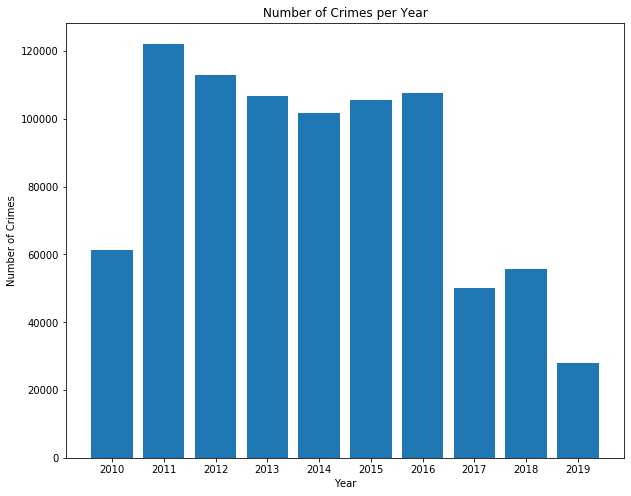

In [12]:
# This udf returns the year of the date
getYear = udf(lambda x : x.year)

# Group by 'Year' and calculate the 'Offence Count' for each year, then return output as list.
year_count = df_date.withColumn('Year', getYear('Reported Date'))\
    .select('Year', 'Offence Count')\
    .groupby('Year').sum('Offence Count').orderBy('Year')\
    .rdd.map(lambda x : (x['Year'], x['sum(Offence Count)'])).collect()

# Create the list for x-axis and y-axis
x1, y1 = [],[]
for i in year_count:
    x1.append(i[0])
    y1.append(i[1])
    
# Creat the bar plot and set the title, labels and size.
fig, ax = mp.subplots() 
ax.bar(x1, y1)
ax.set_title('Number of Crimes per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Crimes')
fig.set_size_inches(10,8)

### Answer 1
The number of crimes is high in previous years. The number of crimes is decreasing since 2017.

### Question 2
Find the number of crimes per month. Plot the graph and explain your understanding of the graph.

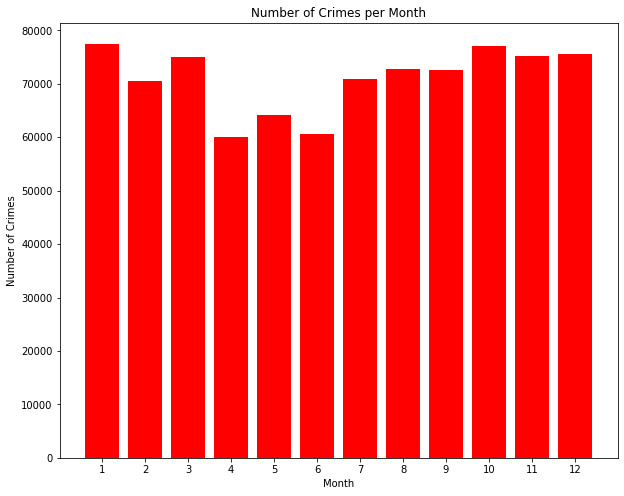

In [13]:
# This udf returns the month of the date
getMonth = udf(lambda x : x.month, IntegerType())

# Group by 'Month' and calculate the 'Offence Count' for each month, then return output as list.
month_count = df_date.withColumn('Month', getMonth('Reported Date'))\
    .select('Month', 'Offence Count')\
    .groupby('Month').sum('Offence Count').orderBy('Month')\
    .rdd.map(lambda x : (x['Month'], x['sum(Offence Count)'])).collect()

# Create the list for x-axis and y-axis
x2, y2 = [],[]
for i in month_count:
    x2.append(str(i[0]))
    y2.append(i[1])

# Creat the bar plot and set the color, title, labels and size.
fig, ax = mp.subplots() 
ax.bar(x2, y2, color = 'red')
ax.set_title('Number of Crimes per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Crimes')
fig.set_size_inches(10,8)

### Answer 2
According to the graph, the number of crimes is high at the beginning and the end of year. The lowest number of crimes occurs from April to June.

### Question 3
Where do most crimes take place? Find the top 20 suburbs (which would also display postcode for e.g. Caulfield-3162 )?. Plot the graph and explain your understanding of the graph.

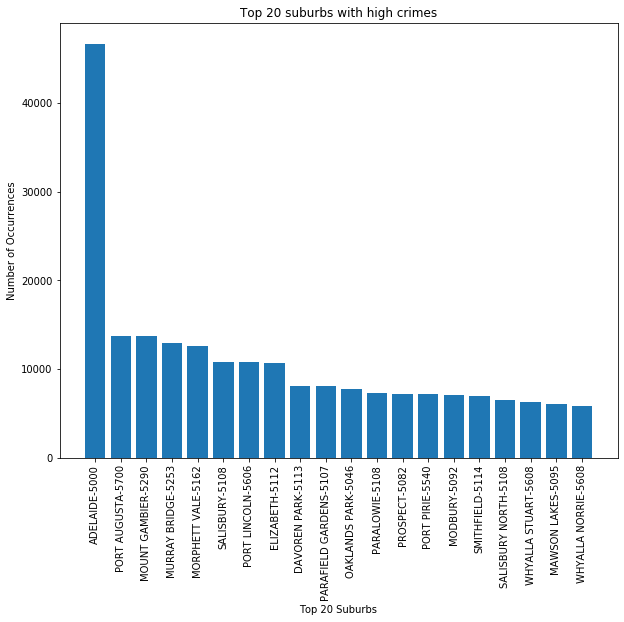

In [14]:
# Calculate the total crimes for each suburb.
df_loc = df.select('Suburb - Incident','Postcode - Incident','Offence Count')\
    .groupby('Suburb - Incident','Postcode - Incident').sum('Offence Count')\
    .orderBy('sum(Offence Count)', ascending = False)

# Remove the record of 'NOT DISCLOSED' and then return output as list.
location_count = df_loc.filter(df_loc['Suburb - Incident'] != 'NOT DISCLOSED').dropna('any').rdd\
    .map(lambda x : (x['Suburb - Incident'] + '-' + x['Postcode - Incident'], x['sum(Offence Count)']))\
    .collect()

# Create the list for x-axis and y-axis
x3, y3 = [],[]
for i in location_count[0:20]:
    x3.append(i[0])
    y3.append(i[1])

# Creat the bar plot and set the title, labels and size.
fig, ax = mp.subplots()
ax.bar(x3, y3)
ax.set_title('Top 20 suburbs with high crimes')
ax.set_xticklabels(x3, rotation = 'vertical')
ax.set_xlabel('Top 20 Suburbs')
ax.set_ylabel('Number of Occurrences')
fig.set_size_inches(10, 8)

### Answer 3
Most crimes take place in ADELAIDE-5000, which is higher than any other suburbs. There are 8 suburbs have more than 10000 crimes.

### Question 4
Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph.

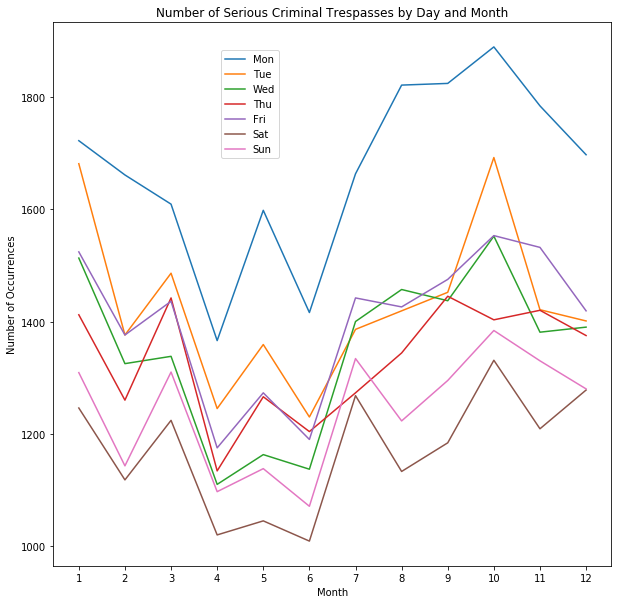

In [15]:
# This udf returns the day by week.
getWeekday = udf(lambda x : x.isoweekday(), IntegerType())

# Sort the data by month and weekday, then return the total count as a list
weekday_count = df.filter(df['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS')\
    .filter(dropNone('Reported Date'))\
    .withColumn('Reported Date',toDate('Reported Date'))\
    .withColumn('Month', getMonth('Reported Date'))\
    .withColumn('Weekday', getWeekday('Reported Date'))\
    .select('Month', 'Weekday', 'Offence Count')\
    .groupby('Month', 'Weekday')\
    .sum('Offence Count')\
    .orderBy('Month', 'Weekday')\
    .rdd.map(lambda x : (x[0], x[1], x[2]))\
    .collect()

# Collect the data by weekday, then save the x-axis and y-axis data in lists.
month = []
days = [[],[],[],[],[],[],[],[]]
week = ['','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in weekday_count:
    month.append(i[0])
    days[i[1]].append(i[2])
month = list(str(x) for x in set(month))

# Creat the line chart and set the title, labels, legend and size.
fig, ax = mp.subplots()
for i in range(1,8):
    ax.plot(month, days[i], label = week[i])
ax.set_title('Number of Serious Criminal Trespasses by Day and Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Occurrences')
mp.legend(loc = (0.3, 0.75))
fig.set_size_inches(10, 10)

### Answer 4
The number of serious criminal trespasses is highest on Monday, the number is lowest on Saturday.